In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from rfest import LNP, splineLNP, LNLN, splineLNLN
from rfest import build_design_matrix
from rfest.utils import get_n_samples, split_data, fetch_data, upsample_data, uvec
from rfest.plot import plot_subunits2d, plot_subunits3d, plot2d, plot3d, compare_LNP_and_LNLN

In [2]:

# Please download the dataset "rgc_new.pickle" manually from https://github.com/huangziwei/data_RFEst
# and put it into the subfolder `./data`

import pickle

with open('./data/rgc_new.pickle', 'rb') as f:
    data = pickle.load(f)
    
stim = data['stim']
trace = data['trace']
tracetime = data['tracetime']
triggertime = data['triggertime']

In [3]:
i = 2
dims = [25, 15, 15]
# dims = [25, 15, 15]
X, y, dt = upsample_data(stim, triggertime[:], trace[:, i], tracetime[:, i])
X = build_design_matrix(X, dims[0], shift=0)
(X_train, y_train), (X_dev, y_dev), (X_test, y_test) = split_data(X, np.maximum(0., gaussian_filter(y, sigma=2, truncate=0.25)), dt, 
                                                                  frac_train=0.5, frac_dev=0.1, verbose=1)

SUMMARY
               N    Minutes   Fraction
Total      37531      20.02        1.0
Train      18769      10.01        0.5
Dev         3750        2.0        0.1
Test       15012       8.01        0.4


Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     8.074	  5184.792	  1403.383	     0.451	     0.040
  300	    51.692	  -145.354	   225.502	     0.716	     0.142
  600	    98.184	  -163.754	   240.467	     0.732	     0.160
  900	   144.553	  -213.003	   219.969	     0.753	     0.162
 1200	   191.398	  -201.604	   238.455	     0.759	     0.143
 1500	   238.180	  -192.123	   221.005	     0.739	     0.156
 1800	   284.987	  -175.686	   238.735	     0.736	     0.140
 2100	   331.939	  -165.532	   236.834	     0.736	     0.147
 2400	   378.797	  -204.101	   247.764	     0.748	     0.126
 2700	   425.733	  -182.242	   232.455	     0.748	     0.131
Stop: reached 3000 steps.

Total time elapsed: 473.010 s.
Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     7.151	  4415.475	   490.230	     0.511	     0.091
  300	    61.756	  -126.478	   145.270	     0.887	     0.160
  600	   119.055	  -146.981	   139.978	     0.877	     0.168
  900	   17

<Figure size 576x288 with 0 Axes>

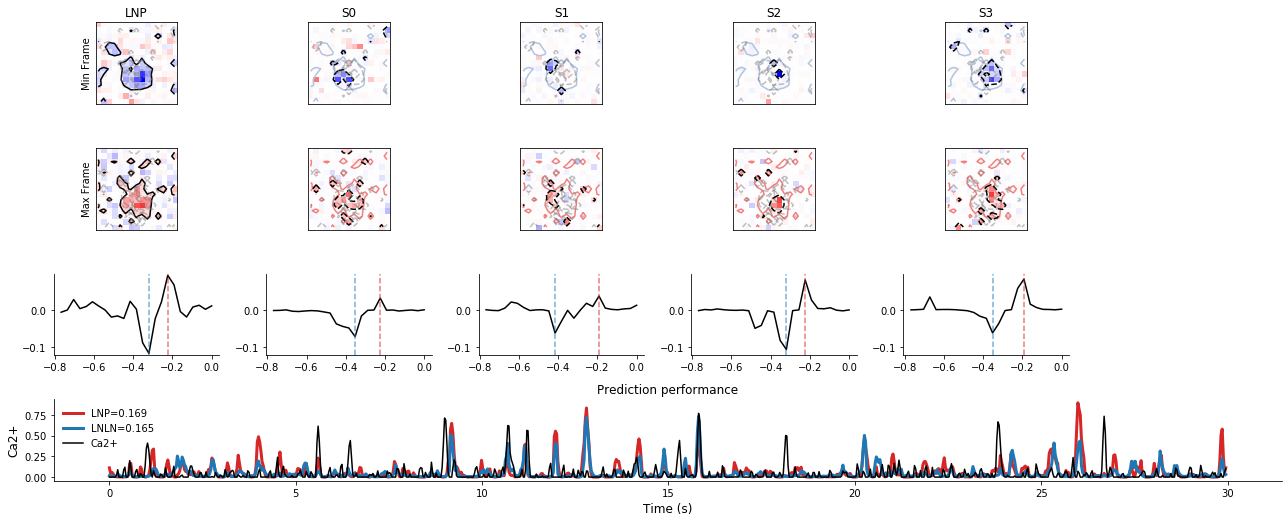

In [14]:
df = [7, 7, 7]
dims = [25, 15, 15]
shift = -0

nospl_lnp = LNP(X_train, y_train, dims=dims, dt=dt)
nospl_lnp.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef', 
         num_iters=3000, verbose=300, tolerance=10,
         beta=1., step_size=0.1, random_seed=2046)

nospl_lnln = LNLN(X_train, y_train, dims=dims, dt=dt)
nospl_lnln.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef', 
         num_subunits=4, num_iters=3000, verbose=300, tolerance=10,
         beta=1., step_size=0.1, random_seed=2046)

fig = compare_LNP_and_LNLN(nospl_lnp, nospl_lnln, X_test, y_test, len_time=30, response_type='Ca2+', shift=0, contour=0.01)

Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     0.653	   646.948	   132.840	     0.243	     0.064
  300	     6.545	    51.189	    74.613	     0.564	     0.339
  600	    14.992	    39.294	    74.326	     0.575	     0.343
  900	    23.471	    33.750	    74.203	     0.579	     0.346
 1200	    31.863	    30.583	    73.932	     0.582	     0.345
 1500	    40.192	    28.272	    73.949	     0.584	     0.347
 1800	    48.580	    26.644	    73.777	     0.586	     0.347
 2100	    57.056	    25.452	    73.713	     0.586	     0.349
 2400	    65.476	    24.400	    73.678	     0.587	     0.349
 2700	    73.840	    23.740	    73.210	     0.588	     0.350
Stop: reached 3000 steps.

Total time elapsed: 82.121 s.
Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     0.744	   616.207	   105.675	     0.228	     0.129
  300	    13.614	   175.183	    58.953	     0.543	     0.378
  600	    28.648	   161.563	    59.813	     0.548	     0.375
Stop at 708 

<Figure size 576x288 with 0 Axes>

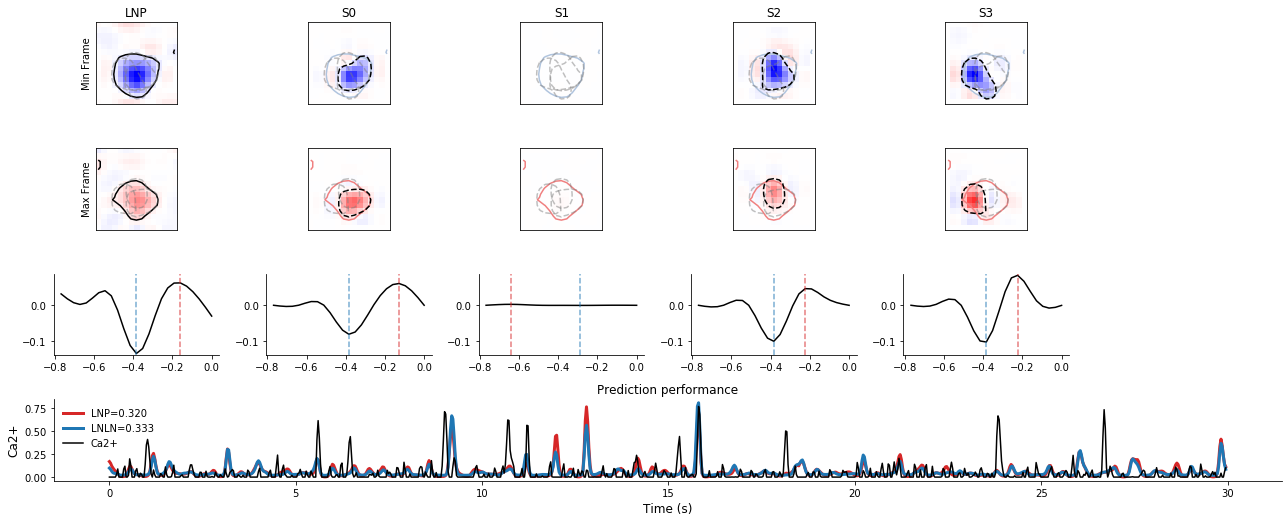

In [11]:
spl_lnp = splineLNP(X_train, y_train, dt=dt, dims=dims, df=df)
spl_lnp.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef',
        num_iters=3000, verbose=300, beta=1., step_size=0.1)

spl_lnln = splineLNLN(X_train, y_train, dt=dt, dims=dims, df=df, filter_nonlinearity='softplus')
spl_lnln.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef',
        num_subunits=4, num_iters=3000, verbose=300, beta=1., step_size=0.1,
        fit_history_filter=False, fit_nonlinearity=False)

fig = compare_LNP_and_LNLN(spl_lnp, spl_lnln, X_test, y_test, len_time=30, response_type='Ca2+', shift=0, contour=0.01)

<Figure size 576x288 with 0 Axes>

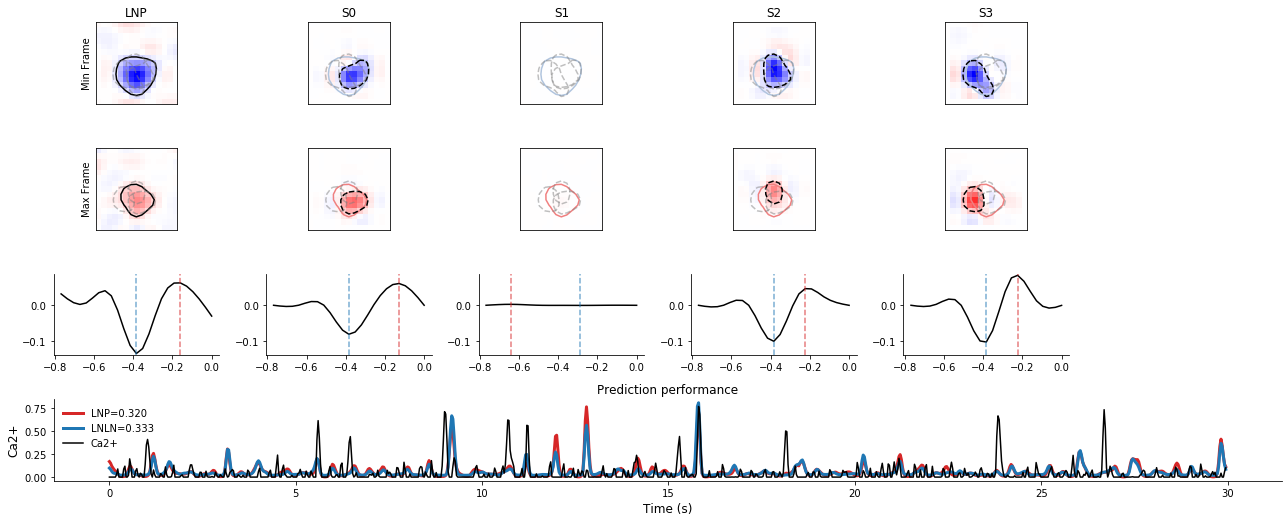

In [16]:
fig = compare_LNP_and_LNLN(spl_lnp, spl_lnln, X_test, y_test, len_time=30, response_type='Ca2+', shift=0, contour=0.02)

In [17]:
from copy import deepcopy
spl_lnln_hist = deepcopy(spl_lnln)
spl_lnln_hist.initialize_history_filter(dims=dims[0], df=6)
spl_lnln_hist.initialize_parametric_nonlinearity(init_to='softplus', method='spline', params_dict={'df': 9})
spl_lnln_hist.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef', 
         num_subunits=4, num_iters=3000, verbose=300, tolerance=10,
         beta=0.3, step_size=0.01, random_seed=2046,
         fit_linear_filter=False, 
         fit_history_filter=True, fit_nonlinearity=True)

Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     2.247	   132.653	    62.832	     0.554	     0.405
  300	    39.060	  -131.259	    28.557	     0.642	     0.519
  600	    79.815	  -207.457	    14.850	     0.679	     0.580
  900	   122.839	  -236.365	     8.152	     0.696	     0.616
 1200	   167.540	  -251.036	     2.933	     0.706	     0.639
 1500	   210.800	  -260.434	    -0.793	     0.712	     0.655
 1800	   254.688	  -266.851	    -3.531	     0.717	     0.667
 2100	   298.824	  -271.437	    -5.586	     0.720	     0.675
 2400	   343.961	  -274.711	    -8.508	     0.722	     0.682
 2700	   386.550	  -277.042	    -9.686	     0.724	     0.687
 3000	   430.100	  -278.794	   -10.536	     0.726	     0.691
 3300	   474.082	  -279.999	   -11.155	     0.727	     0.694
 3600	   518.791	  -280.870	   -11.601	     0.728	     0.697
 3900	   563.357	  -281.518	   -11.922	     0.728	     0.698
 4200	   608.203	  -281.962	   -12.156	     0.728	     0.700
 4500	   653.497

In [38]:
def compare_models(lnp0, lnln0, lnp1, lnln1, lnln2, X_test, y_test, dt=None, shift=None, title=None, response_type='spike', len_time=1, contour=None, figsize=None):
    
    from rfest.utils import get_spatial_and_temporal_filters
    import matplotlib.gridspec as gridspec
    import warnings
    warnings.filterwarnings("ignore")
    
    dims = lnln1.dims
    dt = lnln1.dt if dt is None else dt
    shift = 0 if shift is None else -shift
    t_tRF = np.linspace(-(dims[0]-shift)*dt, shift*dt, dims[0]+1)[1:]

    fig = plt.figure(figsize=figsize) if figsize is not None else (12,4)
    
    for counter, (lnp, lnln) in enumerate([(lnp0, lnln0), (lnp1, lnln1)]):
        
        (idx0, idx1) = (0, 1) if counter == 0 else (2, 3)

        ws = uvec(lnln.w_opt)
        num_subunits = ws.shape[1]

        sRFs_max = []
        sRFs_min = []
        tRFs = []
        for i in range(num_subunits):
            w = ws[:, i].reshape(dims)
            sRF, tRF = get_spatial_and_temporal_filters(w, dims)

            ref = [sRF[2:, 2:].max(), sRF[2:, 2:].min()][np.argmax([np.abs(sRF.max()), np.abs(sRF.min())])]
            max_coord = np.where(sRF == ref)
            tRF = w[:, max_coord[0], max_coord[1]].flatten()
            tRF_max = np.argmax(tRF)
            sRF_max = w[tRF_max]
            sRFs_max.append(sRF_max)
            tRF_min = np.argmin(tRF)
            sRF_min = w[tRF_min]
            sRFs_min.append(sRF_min)
            tRFs.append(tRF)

        sRFs_max = np.stack(sRFs_max)
        sRFs_min = np.stack(sRFs_min)

        vmax = np.max([np.abs(sRFs_max.max()), np.abs(sRFs_max.min()), np.abs(sRFs_min.max()), np.abs(sRFs_min.min())])

        ncols = num_subunits
        ncols += 2 # add lnp, nonlin/history
        nrows = 5

        spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)  
        axs = []
        ax_sRF_mins= []
        ax_sRF_maxs = []    

        # LNP
        w_lnp = uvec(lnp.w_opt).reshape(dims)
        vmax_lnp = np.max([np.abs(w_lnp.max()), np.abs(w_lnp.min())])
        sRF_lnp, tRF_lnp = get_spatial_and_temporal_filters(w_lnp, dims)
        ref = [sRF_lnp[2:, 2:].max(), sRF_lnp[2:, 2:].min()][np.argmax([np.abs(sRF_lnp.max()), np.abs(sRF_lnp.min())])]
        max_coord = np.where(sRF_lnp == ref)
        tRF_lnp = w_lnp[:, max_coord[0], max_coord[1]].flatten()
        tRF_max = np.argmax(tRF_lnp)
        sRF_max = w_lnp[tRF_max]
        tRF_min = np.argmin(tRF_lnp)
        sRF_min = w_lnp[tRF_min]

        ax_sRF_min = fig.add_subplot(spec[idx0, 0])       
        ax_sRF_min.imshow(sRF_max, cmap=plt.cm.bwr, vmax=vmax_lnp, vmin=-vmax_lnp, aspect='auto')
        ax_sRF_min.set_xticks([])
        ax_sRF_min.set_yticks([])
        if counter == 0:
            ax_sRF_min.set_title(f'LNP')

        if counter == 0:
            ax_sRF_min.set_ylabel('No Spline')
        else:
            ax_sRF_min.set_ylabel('Spline')
            
        ax_sRF_mins.append(ax_sRF_min)
        
        ax_tRF = fig.add_subplot(spec[idx1, 0])       
        ax_tRF.plot(t_tRF, tRF_lnp, color='black')
        ax_tRF.spines['top'].set_visible(False)
        ax_tRF.spines['right'].set_visible(False)
#         ax_tRF.set_yticks([])
        ax_tRF.set_xticks([])
        tRF_max = np.argmax(tRFs[i])
#         tRF_min = np.argmin(tRF_lnp)
        ax_tRF.axvline(t_tRF[tRF_max], color='C3', linestyle='--', alpha=0.6)
#         ax_tRF.axvline(t_tRF[tRF_min], color='C0', linestyle='--', alpha=0.6)
        ax_tRF.set_ylim(-0.15, 0.15)
        # LNLN subunits

        for i in range(num_subunits):
            ax_sRF_min = fig.add_subplot(spec[idx0, i+1])       
            ax_sRF_min.imshow(sRFs_max[i], cmap=plt.cm.bwr, vmax=vmax, vmin=-vmax, aspect='auto')
            ax_sRF_min.set_xticks([])
            ax_sRF_min.set_yticks([])
            if i == 0 and counter == 0:
                ax_sRF_min.set_title(f'LNLN')

            ax_sRF_mins.append(ax_sRF_min)
            
            ax_tRF = fig.add_subplot(spec[idx1, i+1])       
            ax_tRF.plot(t_tRF, tRFs[i], color='black')
            ax_tRF.spines['top'].set_visible(False)
            ax_tRF.spines['right'].set_visible(False)
            ax_tRF.set_yticks([])
            ax_tRF.set_xticks([])
            tRF_max = np.argmax(tRFs[i])
#             tRF_min = np.argmin(tRFs[i])
            ax_tRF.axvline(t_tRF[tRF_max], color='C3', linestyle='--', alpha=0.6)
#             ax_tRF.axvline(t_tRF[tRF_min], color='C0', linestyle='--', alpha=0.6)
            ax_tRF.set_ylim(-0.15, 0.15)


        if contour is not None and counter == 1: # then plot contour

            for i in range(num_subunits+1):

                color_min = 'black' if i == 0 else 'lightsteelblue'
                color_max = 'black' if i == 0 else 'lightcoral'

                ax_sRF_mins[i].contour(sRF_max, levels=[contour], colors=[color_max], linestyles=['-'], alpha=1)

                for j in range(num_subunits):
                    if i-1 != j:
                        color = 'grey'
                        alpha = 0.5
                        style = '--'                    
                    else:
                        color = 'black'
                        alpha = 1
                        style = '--'
                    ax_sRF_mins[i].contour(sRFs_max[j], levels=[contour], colors=[color], linestyles=[style], alpha=alpha)
                    
#     ax_his = fig.add_subplot(spec[0, 5])    
#     ax_his.plot()
    
    for i in range(num_subunits):
        
        ax_nl = fig.add_subplot(spec[4, i+1]) 
        xrng = lnln2.nl_xrange
        nl_opt = lnln2.fnl_fitted(lnln2.nl_params_opt[i], lnln2.nl_xrange)
        ax_nl.plot(xrng, nl_opt, color='black', linewidth=2)
        ax_nl.plot(xrng, lnln2.nl_basis * lnln2.nl_params_opt[i], color='grey', alpha=0.5) 
    
        ax_nl.spines['top'].set_visible(False)
        ax_nl.spines['right'].set_visible(False) 
        ax_nl.set_ylim(0, 6)
        
        if i == 0:
            ax_nl.set_ylabel('Fitted nonlinearity')
    else:
        
        dims_h = len(lnln2.h_opt)
        t_hRF = np.linspace(-(dims_h+1)*dt, -1*dt, dims_h+1)[1:]
        ax_h_opt = fig.add_subplot(spec[4, i+2]) 
        ax_h_opt.plot(t_hRF, lnln2.h_opt, color='black', linewidth=2)
        ax_h_opt.plot(t_hRF, lnln2.Sh * lnln2.bh_opt, color='grey', alpha=0.5)
        ax_h_opt.set_title('History Filter')
        ax_h_opt.spines['top'].set_visible(False)
        ax_h_opt.spines['right'].set_visible(False)         
                    
    ax_bar = fig.add_subplot(spec[0, 5])  
    div = int(X_test.shape[0]/4)

    cc_test = np.array([[m.score(X_test[i*div:(i+1)*div], y_test[i*div:(i+1)*div]) for m 
                         in [lnp0, lnp1, lnln0, lnln1, lnln2]] for i
                         in range(4)])

    cc_test_mean = cc_test.mean(0)
    cc_test_std = cc_test.std(0)

    x = [0, 1, 2, 3, 4]
    ax_bar.bar(x, cc_test_mean, yerr=cc_test_std, width=1, color=['lightblue', 'lightcoral', 'steelblue', 'firebrick', 'red'], capsize=5)
    labels = ['LNP', 'LNP (spline)', 'LNLN', 'LNLN (spline)', 'LNLN (spline) w/ extra']


    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)
    ax_bar.set_xticks(x)
    ax_bar.set_xticklabels(labels, rotation=90)
#     ax_bar.set_ylim(0, 0.5)

    plt.subplots_adjust(wspace=0.5)





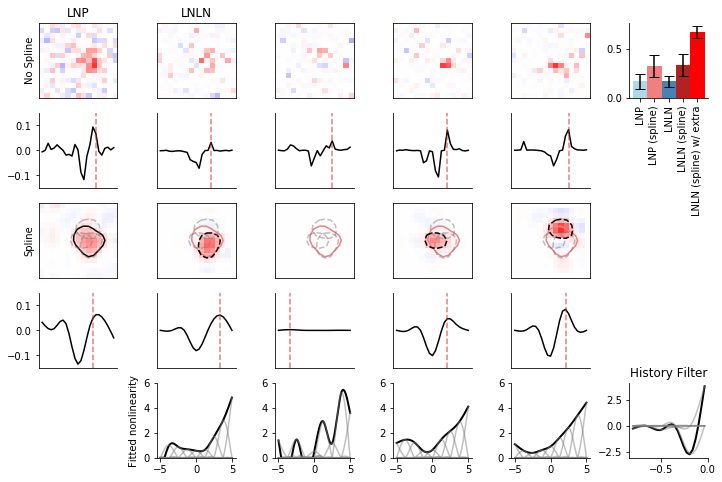

In [41]:
compare_models(nospl_lnp, nospl_lnln, spl_lnp, spl_lnln, spl_lnln_hist, X_test, y_test, dt=None, shift=None, contour=0.02,
               figsize=(12, 3*2+2))

plt.savefig('figs/fig5d.pdf')